<a href="https://colab.research.google.com/github/ZhuoquanChen/Data-Science-Projects/blob/main/%20Future_Sales_Prediction/Future_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Future Sales Prediction
This project leverages AI and machine learning to develop a predictive model, which is able to forecast sales in future based on historical data while taking into account  the affects of seasonality, holidays, promotions and competitions.
- Predicted future product salses
- Applied time series forecasting model: Facebook Prophet time series model
- Additive regression
- Predicted sales trend by weekly, monthly and yearly

## - Problem Statement
For companies to become more competitive and grow strongly, they need to leverage AI/ML to develop predictive models to forecast sales in future. In this case, I will work as a Data Scientist in Sales Department, which the objective is that to predict future daily sales based on historical data while taking into various of features. 

## - Import Libraries and Data
Data Source: https://www.kaggle.com/c/rossmann-store-sales/data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='white')
import datetime

%matplotlib inline

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
sales_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Data_Scieence_Business_Projects/Future_Sales _Prediction/train.csv')
sales_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


**There are two datasets in this project:**

This is the first dataset
- Id: transaction ID (combination of Store and date) 
- Store: unique store Id
- Sales: sales/day, this is the target variable 
- Customers: number of customers on a given day
- Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
- Promo: describes if store is running a promo on that day or not
- StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

In [25]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


- 9 columns in total 
- 8 features, each contains 1017209 data points
- 1 target variable (sales)

In [26]:
sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


- Average sales amount per day = 5773 dollars, minimum sales per day = 0, maximum sales per day = 41551 
- Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

In [27]:
stores_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Data_Scieence_Business_Projects/Future_Sales _Prediction/store.csv')
stores_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


This is the second dataset: store.csv
- Store: store id number
- StoreType: categorical variable to indicate type of store (a, b, c, d)
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance (meters): distance to closest competitor store
- CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
- Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
- Promo2Since [Year/Week]: date when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [28]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


- This dataframe only includes information about the unique 1115 stores

In [29]:
stores_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


- on average, the competition distance is 5404 meters away (5.4 kms)

## - Exploratory Data Analysis

### 1. Exploring 'sales_df' Dataset

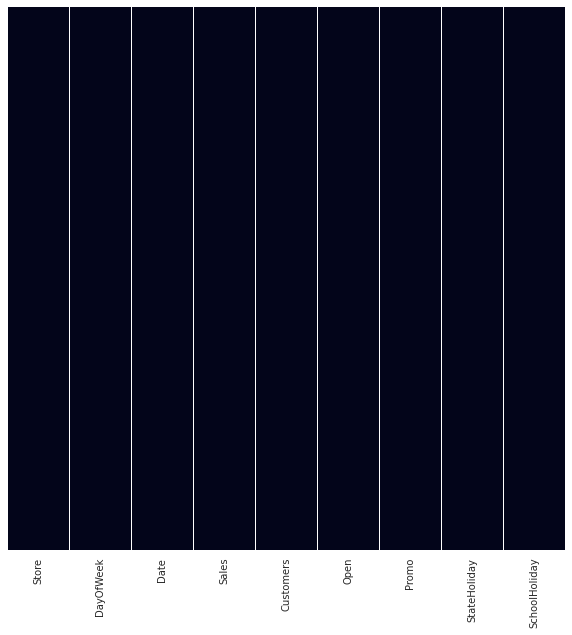

In [30]:
# Missing data checking for sasels_df

plt.figure(figsize=(10, 10))
sns.heatmap(sales_df.isnull(), yticklabels=False, cbar=False);

In [31]:
sales_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

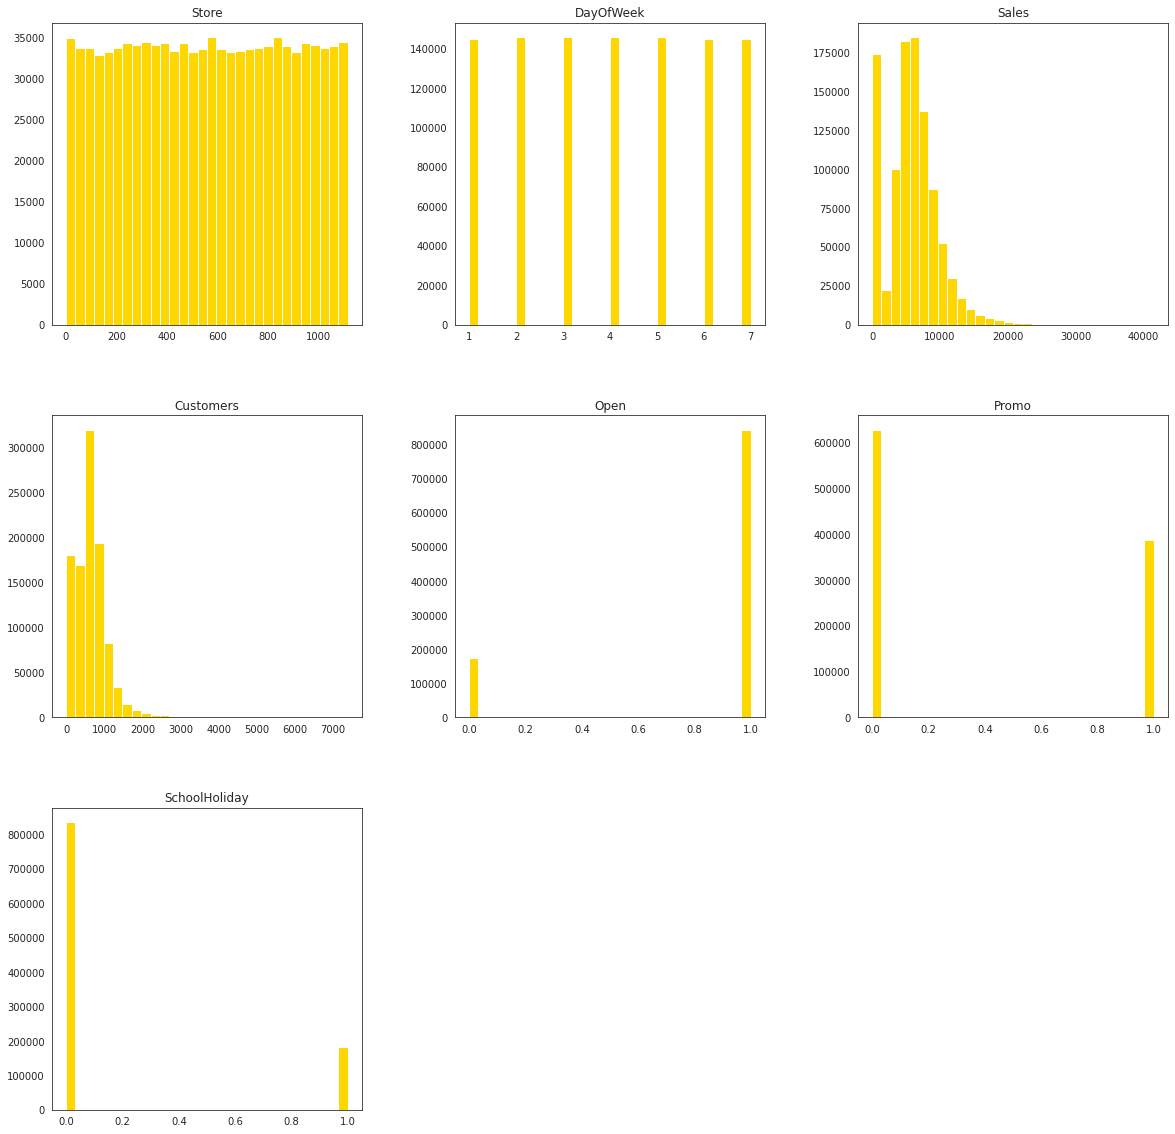

In [32]:
# Using histgram to display the distributed status of all of numerical columns 

sales_df.hist(bins=30, figsize=(20, 20), color='gold', grid=False);

- Average 600 customers per day, maximum is 4500 (note that describe shows that 7388 so it should be a outlier!)
- Data is equally distibuted across various Days of the week (~150000 observations x 7 day = ~1.1 million observation) 
- Stores are open ~80% of the time
- Data is equally distributed among all stores (no bias)
- Promo #1 was running ~40% of the time 
- Average sales around 5000-6000 Euros
- School holidays are around ~18% of the time

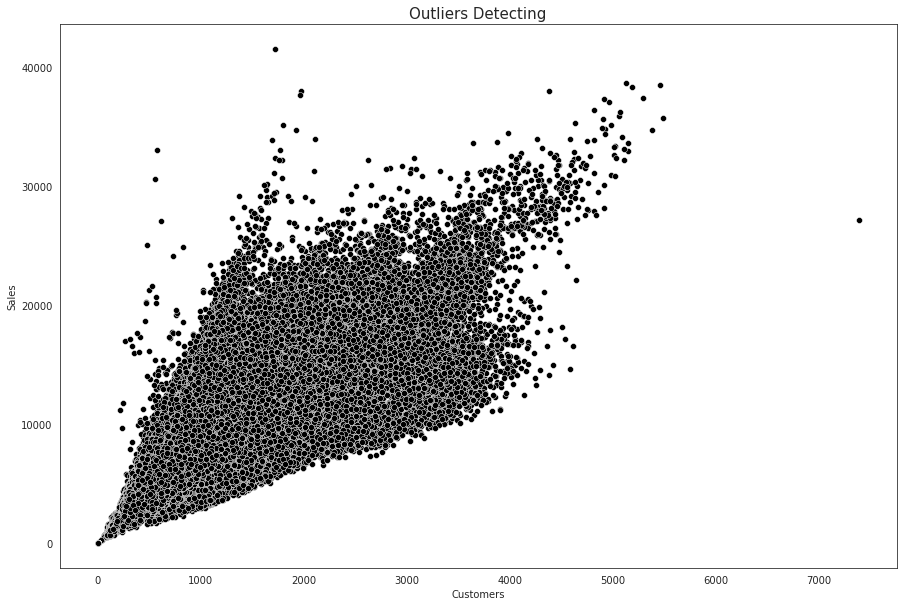

In [33]:
# Check outlier of customers

plt.figure(figsize=(15, 10))
sns.scatterplot(x='Customers', y='Sales', data=sales_df, color='black')
plt.title('Outliers Detecting', fontdict={'fontsize': 15});

The total number of stores: 1017209
The total number of stores opened: 844392
The total number of stores closed: 172817
 


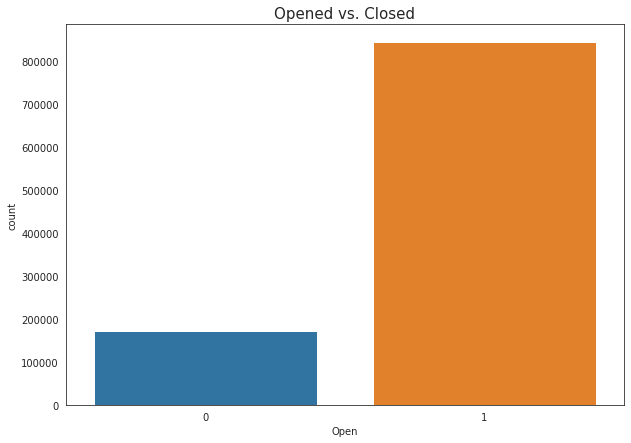

In [34]:
# The number of stores are opened and closed

store_opened = sales_df[sales_df['Open'] == 1]
store_closed = sales_df[sales_df['Open'] == 0]

print('The total number of stores:', len(sales_df))
print('The total number of stores opened:', len(store_opened))
print('The total number of stores closed:', len(store_closed))
print(' ')

plt.figure(figsize=(10, 7))
sns.countplot(x='Open', data=sales_df)
plt.title('Opened vs. Closed', fontdict={'fontsize': 15});

In [35]:
# Since the closed stores had no sales, so remove them.

sales_df = sales_df[sales_df['Open'] == 1]
sales_df.shape

(844392, 9)

In [36]:
# After now all are opened stores, so we can drop 'Open' column

sales_df.drop(columns=['Open'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
sales_df.shape

(844392, 8)

In [39]:
# After dropping those closed stores, the average value went up

sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


In [40]:
# Reset the index to be consecutive numbers

sales_df.reset_index(drop=True)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,0,a,1
844388,733,2,2013-01-01,10765,2377,0,a,1
844389,769,2,2013-01-01,5035,1248,0,a,1
844390,948,2,2013-01-01,4491,1039,0,a,1


### 2. Exploring store_df Dataset

In [42]:
stores_df.shape

(1115, 10)

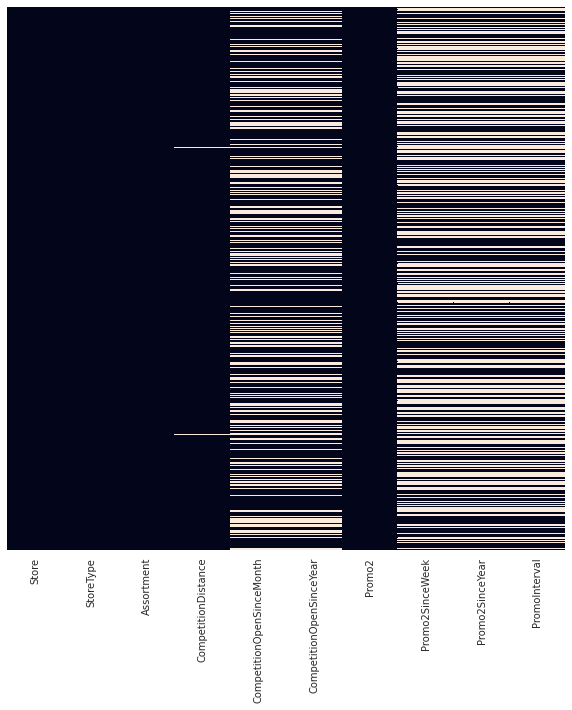

In [43]:
# Check the missing data

plt.figure(figsize=(10, 10))
sns.heatmap(stores_df.isnull(), yticklabels=False, cbar=False);

In [45]:
stores_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [48]:
# Check the 'CompetitionDistance', which has 3 missing data

stores_df[stores_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [49]:
# Chenck the 'CompetitionOpenSinceMonth', which has 354 missing data of 1115

stores_df.loc[stores_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [50]:
# Once 'Promo2' is 0, then 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 
# 'Promo2SinceYear' and 'PromoInterval' are 0 because giving week, month and year an average value not make sense, 
# So 'Promo2SinceWeek', 'Promo2SinceYear' and 'PromoInterval' will be done, only leaving some still missing of 
# 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' when 'Promo2' is 1.

promo2_is_zero = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

for i in promo2_is_zero:
    stores_df[i].fillna(0, inplace=True)

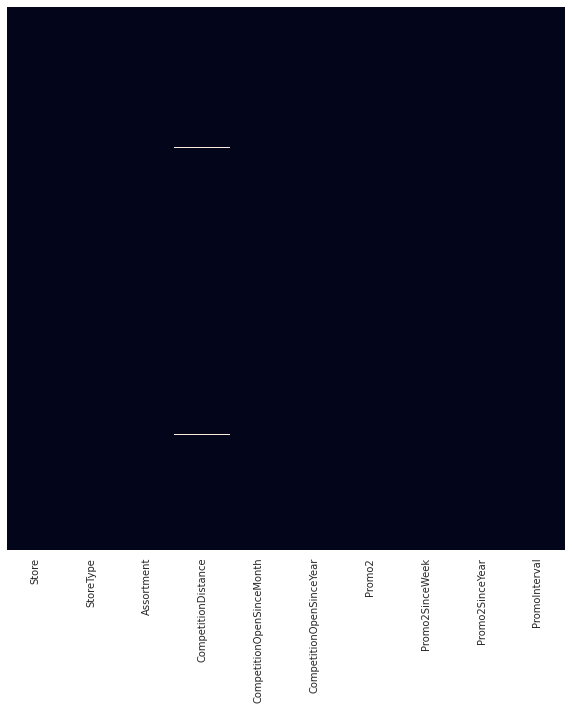

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(stores_df.isnull(), yticklabels=False, cbar=False);

In [52]:
# Now only leaves column 'CompetitionDistance', which is a distance. We can give it a mean value for missing data

stores_df['CompetitionDistance'].fillna(stores_df['CompetitionDistance'].mean(), inplace=True)

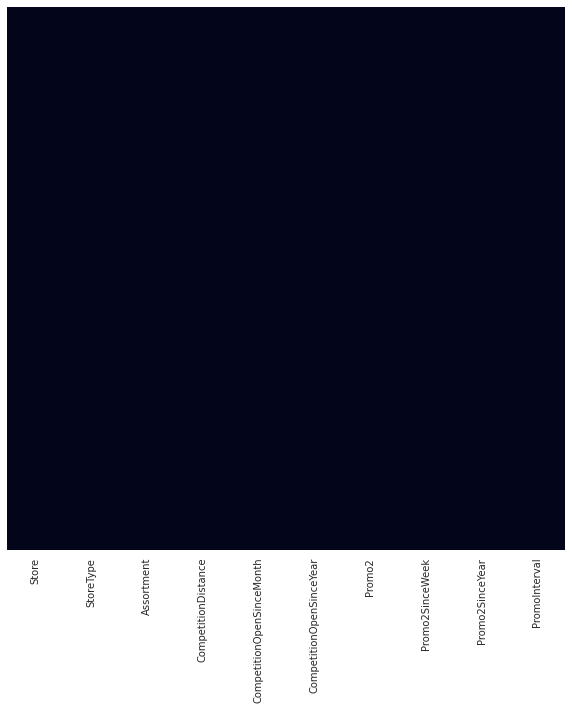

In [53]:
plt.figure(figsize=(10, 10))
sns.heatmap(stores_df.isnull(), yticklabels=False, cbar=False);

In [55]:
stores_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

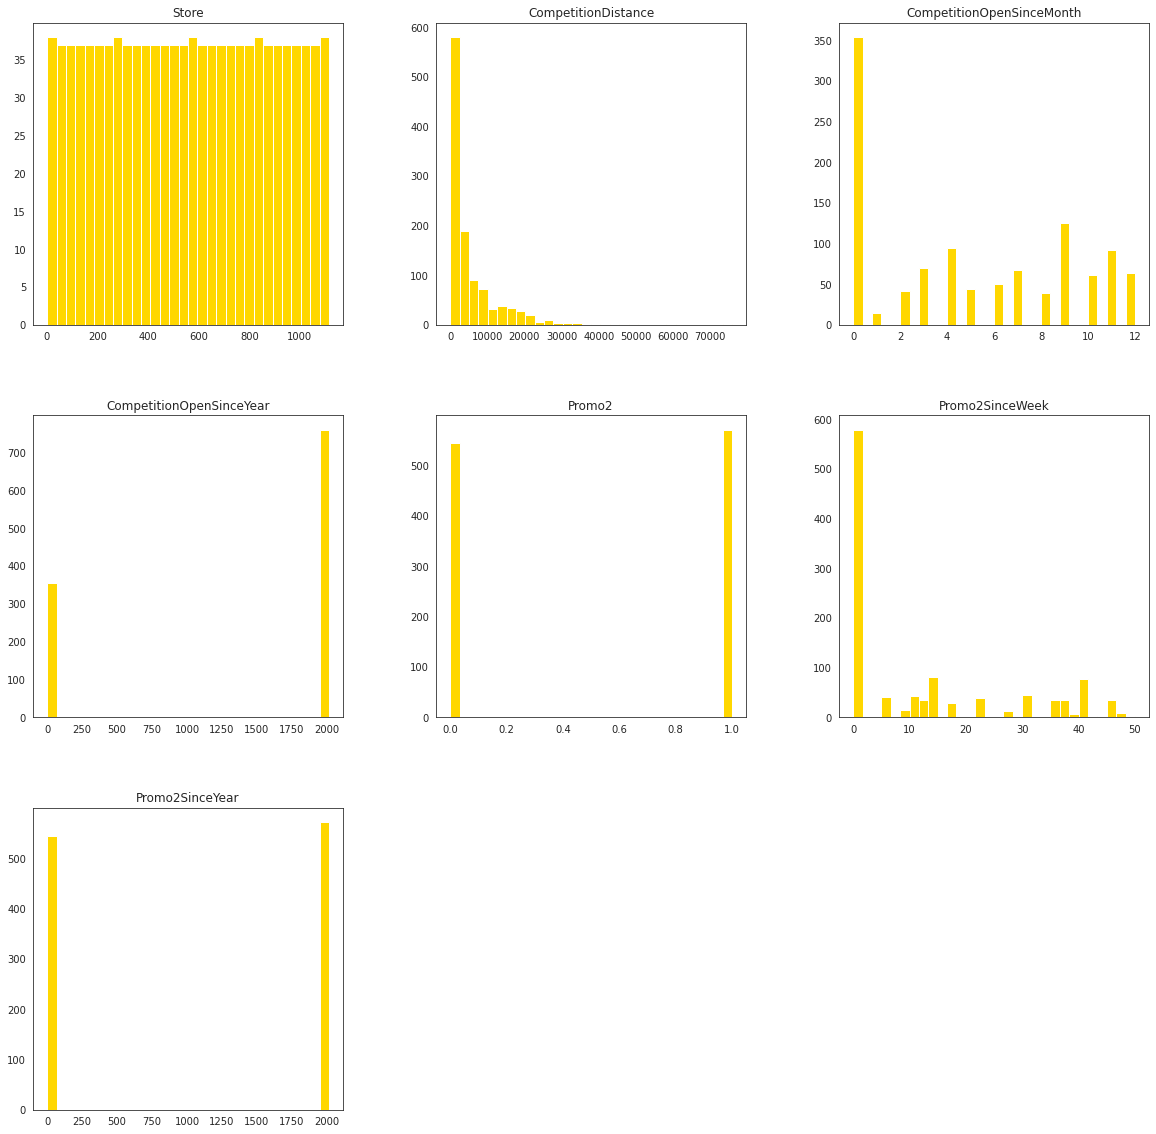

In [56]:
# Using histgram to display the distributed status of all of numerical columns 

stores_df.hist(bins=30, figsize=(20, 20), color='gold', grid=False);

- Half of stores are involved in promo 2
- Half of the stores have their competition at a distance of 0-3000m (3 kms away)

### 3. Exploring Merged Data Frames

In [57]:
sales_df.shape

(844392, 8)

In [58]:
stores_df.shape

(1115, 10)

In [59]:
combined_df = pd.merge(left=sales_df, right=stores_df, how='inner', on='Store')
combined_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [60]:
# How 'Sales' correlates with each feture

correlation = combined_df.corr()['Sales'].sort_values()
correlation

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

- Customer and Promo have obvious correlation with Sales
- Promo2 does not seem to be effective at all

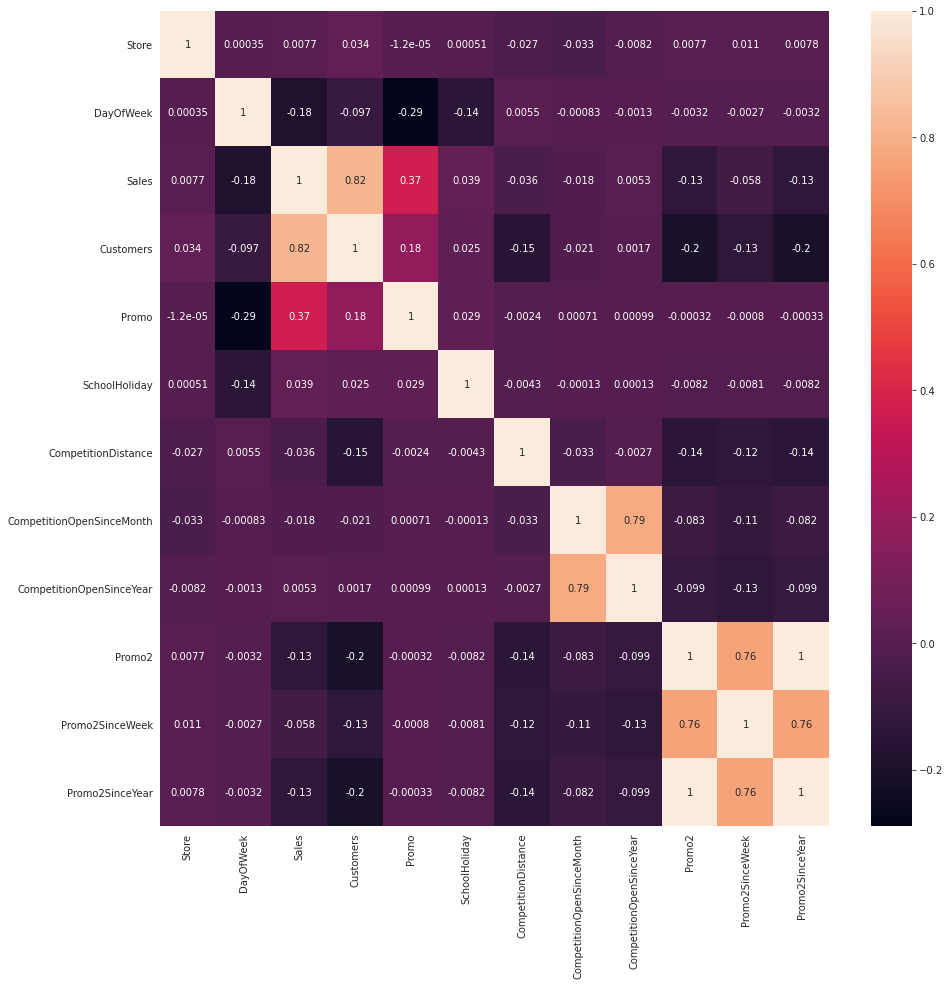

In [61]:
# Display the correlations on heatmap

plt.figure(figsize=(15, 15))
sns.heatmap(combined_df.corr(), annot=True);

In [62]:
# Discomposing 'Date' column into year, month and day by DatetimeIndex function

combined_df['Year'] = pd.DatetimeIndex(combined_df['Date']).year
combined_df['Month'] = pd.DatetimeIndex(combined_df['Date']).month
combined_df['Day'] = pd.DatetimeIndex(combined_df['Date']).day

combined_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [63]:
# The average 'Sales' and 'Customers' per month

avg_per_month = combined_df.groupby('Month')[['Sales', 'Customers']].mean()
avg_per_month

,Sales,Customers
Month,,
1,6563.690444,722.514749
2,6589.165535,731.504792
3,6976.412026,759.081600
4,7046.228420,774.271806
5,7106.453154,779.290214
6,7000.978190,759.277357
7,6952.682125,752.745522
8,6648.984654,750.384706
9,6546.343035,745.613988


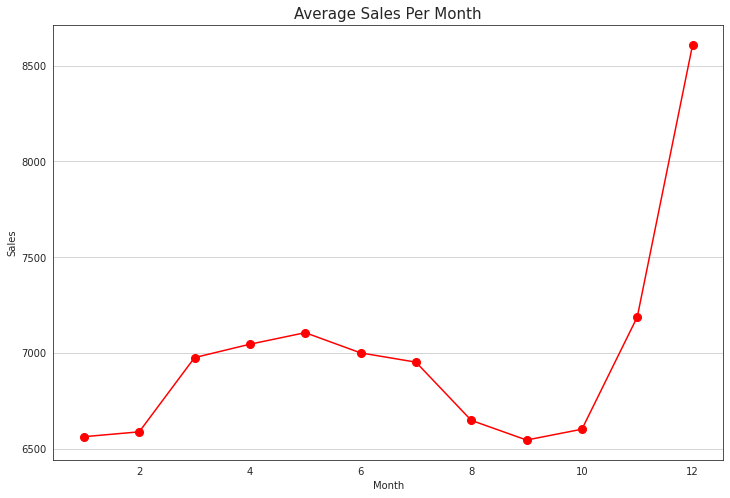

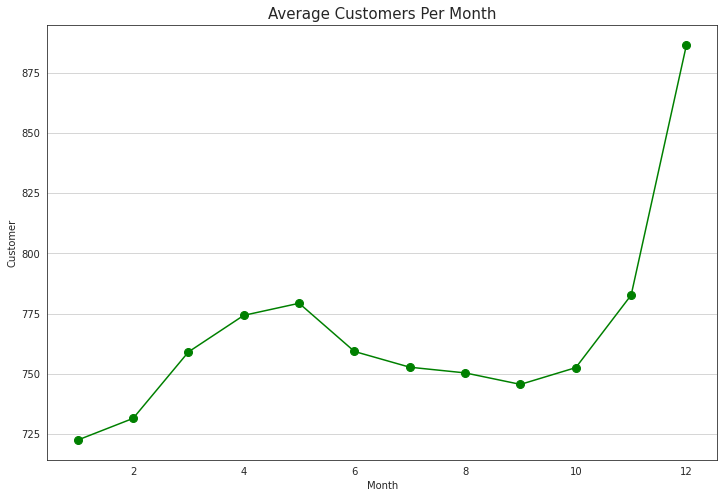

In [64]:
# Visualizing above data

avg_per_month['Sales'].plot(figsize=(12, 8), marker='o', markersize=8, color='red')
plt.grid(axis='y')
plt.ylabel('Sales')
plt.title('Average Sales Per Month', fontdict={'fontsize': 15})

plt.figure()

avg_per_month['Customers'].plot(figsize=(12, 8), marker='o', markersize=8, color='green')
plt.grid(axis='y')
plt.ylabel('Customer')
plt.title('Average Customers Per Month', fontdict={'fontsize': 15});

In [65]:
# The average 'Sales' and 'Customers' per day in a month

avg_per_day = combined_df.groupby('Day')[['Sales', 'Customers']].mean()
avg_per_day

,Sales,Customers
Day,,
1,8053.674102,846.284593
2,7987.452335,842.344108
3,7765.296991,818.100766
4,7745.844134,819.085296
5,7554.982112,802.752484
6,7149.914351,778.836139
7,7101.113826,776.275080
8,6785.121061,757.211580
9,6499.276895,730.633183


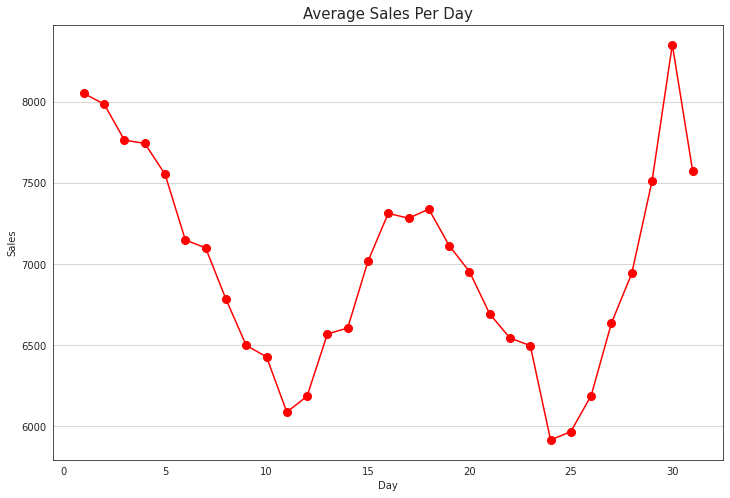

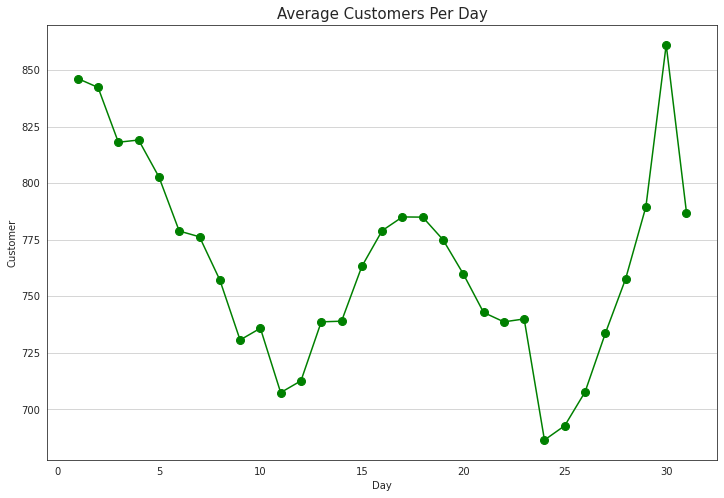

In [66]:
# Visualizing above data

avg_per_day['Sales'].plot(figsize=(12, 8), marker='o', markersize=8, color='red')
plt.grid(axis='y')
plt.ylabel('Sales')
plt.title('Average Sales Per Day', fontdict={'fontsize': 15})

plt.figure()

avg_per_day['Customers'].plot(figsize=(12, 8), marker='o', markersize=8, color='green')
plt.grid(axis='y')
plt.ylabel('Customer')
plt.title('Average Customers Per Day', fontdict={'fontsize': 15});

In [67]:
# The average 'Sales' and 'Customers' per day in a week

avg_per_day_in_week = combined_df.groupby('DayOfWeek')[['Sales', 'Customers']].mean()
avg_per_day_in_week

,Sales,Customers
DayOfWeek,,
1,8216.073074,855.444984
2,7088.113656,769.986753
3,6728.122978,740.598876
4,6767.310159,755.569784
5,7072.677012,781.771639
6,5874.840238,660.177526
7,8224.723908,1441.532424


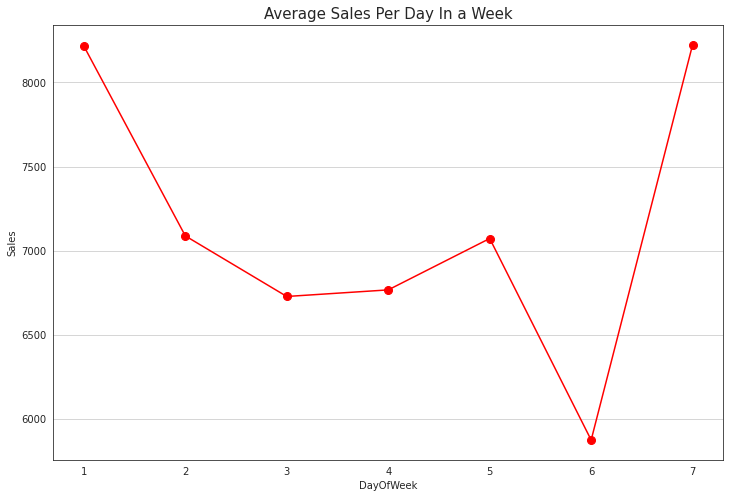

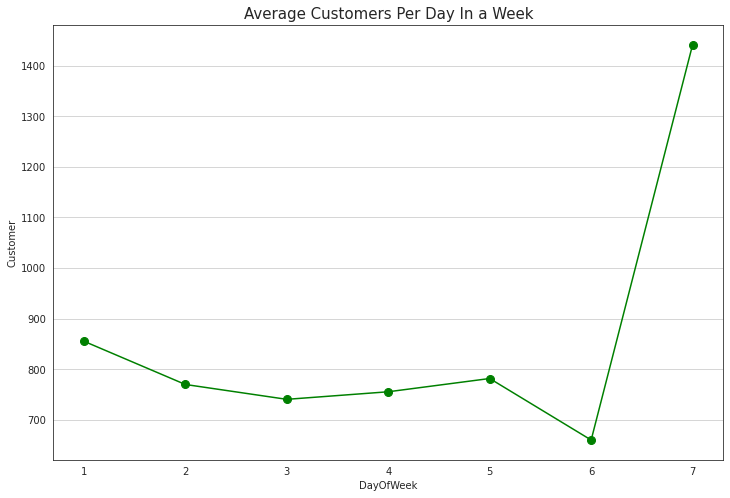

In [68]:
# Visualizing above data

avg_per_day_in_week['Sales'].plot(figsize=(12, 8), marker='o', markersize=8, color='red')
plt.grid(axis='y')
plt.ylabel('Sales')
plt.title('Average Sales Per Day In a Week', fontdict={'fontsize': 15})

plt.figure()

avg_per_day_in_week['Customers'].plot(figsize=(12, 8), marker='o', markersize=8, color='green')
plt.grid(axis='y')
plt.ylabel('Customer')
plt.title('Average Customers Per Day In a Week', fontdict={'fontsize': 15});

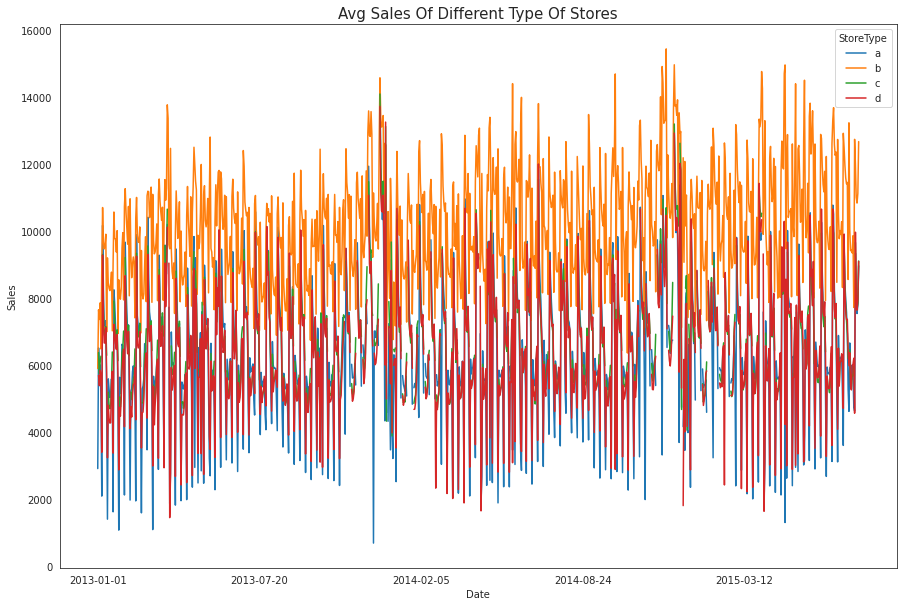

In [69]:
# Average 'Sales' of different type of stores

avg_diff_store = combined_df.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(figsize=(15, 10))
plt.title('Avg Sales Of Different Type Of Stores', fontdict={'fontsize': 15})
plt.ylabel('Sales');

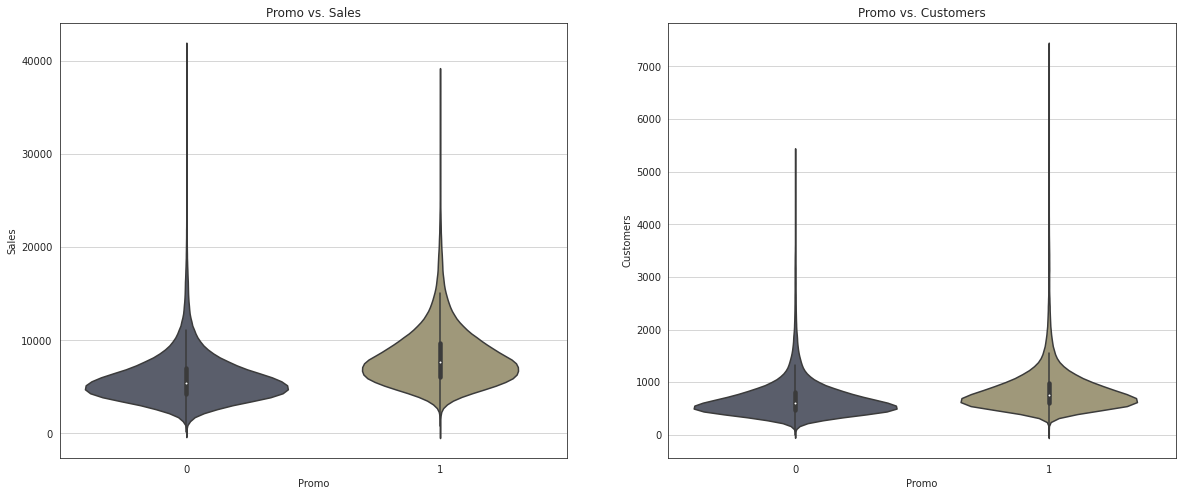

In [70]:
# How does the promo effect Sales and Customers

# promo

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='Promo', y='Sales', data=combined_df, palette='cividis')
plt.grid(axis='y')
plt.title('Promo vs. Sales')

plt.subplot(1, 2, 2)
sns.violinplot(x='Promo', y='Customers', data=combined_df, palette='cividis')
plt.grid(axis='y')
plt.title('Promo vs. Customers');

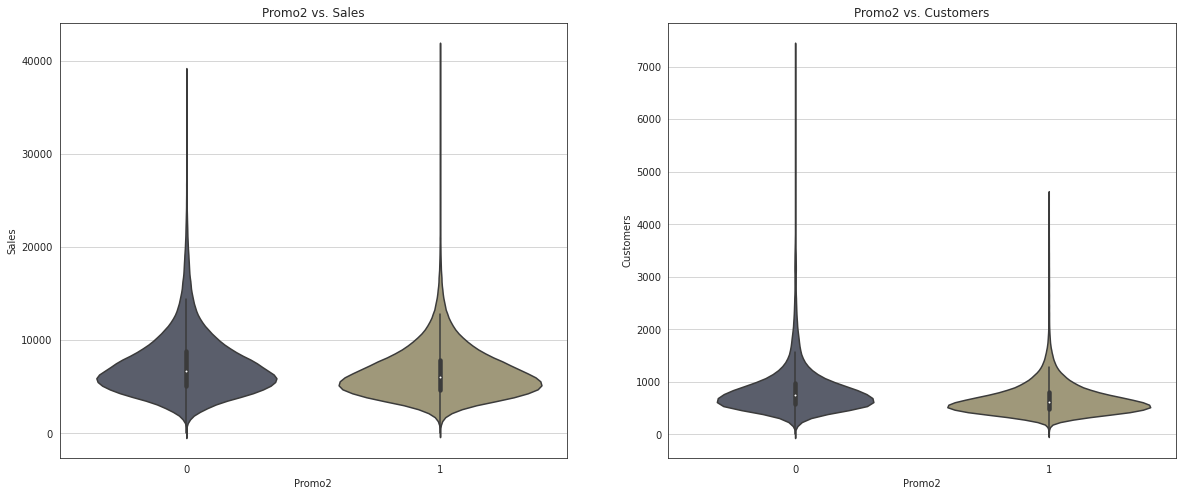

In [71]:
# promo2

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='Promo2', y='Sales', data=combined_df, palette='cividis')
plt.grid(axis='y')
plt.title('Promo2 vs. Sales')

plt.subplot(1, 2, 2)
sns.violinplot(x='Promo2', y='Customers', data=combined_df, palette='cividis')
plt.grid(axis='y')
plt.title('Promo2 vs. Customers');

## - Facebook Prophet Model